#  XPCS   Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [2]:
hdr = db[{{ uid }}]

NameError: name 'uid' is not defined

In [3]:
cd /home/yuzhang/chx-pipelines/Develops/

/home/yuzhang/chx-pipelines/Develops


In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
from ipywidgets import interact

In [ ]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/

In [7]:
%run develop.py
%run two_time.py

In [8]:
%matplotlib notebook
#%matplotlib inline

# Users put 
* uid for Bluesky Scan
* filename for acquiring data directly by EigerSofteare

In [9]:
BlueScan = True
DirectAcq = False
detector = 'eiger_4M_cam_img_image_lightfield'  #for 4M

# Users put uid here

In [10]:
if BlueScan:
    uid = '54614d43'
    #uid = '95782687'
    uid = '95782687'
    uid= 'ff9f20c0'
    uid='71720966'
    uid='1663d34a'
    uid = 'f505e052-3baa-47d4-bdc4-61c2eb1bcc7a'  #sid= 551, 1%PEG, 
    uid='ee6975a1-9161'   #1% wt PEG
    
else:
    uid = '/XF11ID/data/2015/11/23/d01ab510-3cf3-4719-bee3_795_master.h5' 

### Get data

In [13]:
if BlueScan:
    hdr = db[uid]
    ev, = get_events(  hdr, [detector] )
    imgs = ev['data'][detector]
else:    
    imgs =  Images(uid)
print (imgs)
Nimg=len(imgs)

hdf5 path = /XF11ID/data/2015/11/23/5f7b93e2-71ef-41b0-9c2c_138_master.h5
<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


### Get data path

In [14]:
if BlueScan:
    from datetime import datetime
    dt = datetime.fromtimestamp(hdr['start'].time)
    path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
else:
    path ='/XF11ID/analysis/2015/11/23/' 
path

'/XF11ID/analysis/2015/11/23/'

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [15]:
imgs.md

{'beam_center_x': 852.0,
 'beam_center_y': 1830.0,
 'count_time': 0.0049899998,
 'detector_distance': 4.8400002,
 'frame_time': 0.0049999999,
 'framerate': 200.00000447034847,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [16]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4812.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(0.0049999999, 0.0049899998)

## load a mask
#### load the mask saved in the mask_pipeline

In [17]:
mask = np.load( path +  str(uid)+ "_mask.npy")


### Reverse the mask in y-direction due to the coordination difference between python and Eiger software 

In [18]:
maskr = mask[::-1,:]

## Plot the mask

<IPython.core.display.Javascript object>


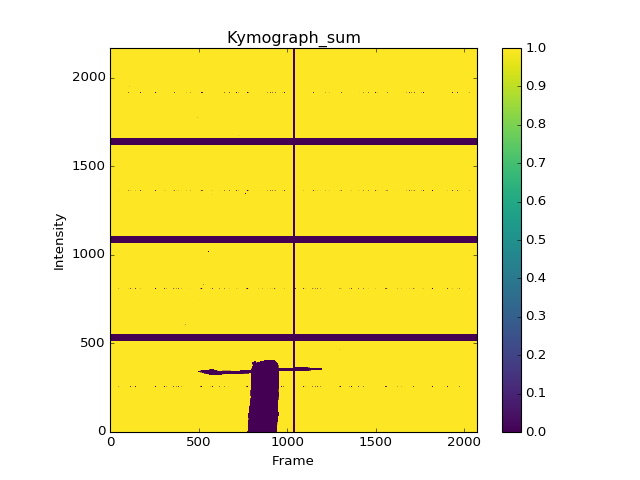

In [58]:
fig, ax = plt.subplots()
im=ax.imshow(maskr, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

In [20]:
def view_image(i):    
    fig, ax = plt.subplots()
    ax.imshow(imgs[i]*mask, interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm(vmin=0.001, vmax=1e1) )
    ax.set_title("Browse the Image Stack")
    plt.show()
    

In [21]:
#interact(view_image, i=(0, Nimg-1))

## Movie

In [22]:
def view_image(sleeps=1, ims=0, ime = 1):    
    fig, ax = plt.subplots()  
    for i in range( ims, ime  ):
        im=ax.imshow(imgs[i]*mask,  interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm( vmin=0.01, vmax=10 ) )
        ax.set_title("images_%s"%i)
        
        time.sleep( sleeps )
        plt.draw()
    #fig.colorbar(im)
        
#view_image(.2, 0, 2)

### hey, let's see if any images are bad!

#### load the image intensity (kymograph) saved in the mask_pipeline

In [23]:
kymo_sum = np.load( path +  str(uid)+"_kymo_sum.npy" ) 

<IPython.core.display.Javascript object>


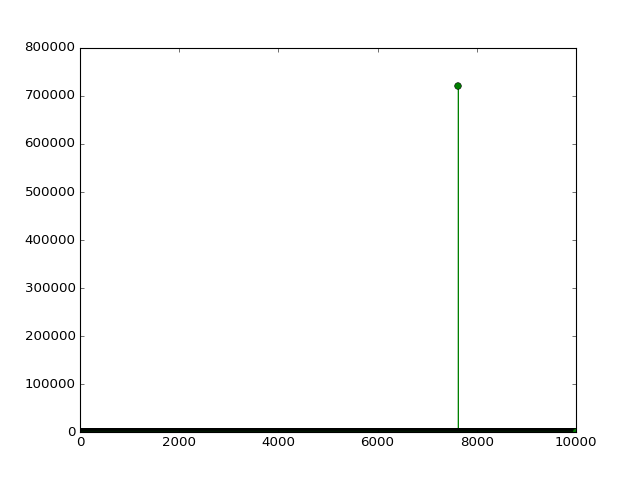

In [59]:
fig, axes = plt.subplots(  )
axes.plot( kymo_sum, '-go'  ) 
ax.set_ylabel('Intensity')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_sum') 
plt.show()

### Get the Averaged Image Data

#### load the average intensity saved in the mask_pipeline

In [25]:
avg_img = np.load( path + str(uid)+"_avg_img.npy" )
avg_imgm =  avg_img * mask

### Reverse the image in y-direction due to the coordination difference between python and Eiger software 

In [26]:
avg_imgr  = avg_img[::-1,:] 
avg_imgmr  = avg_imgm[::-1,:] 

## Plot the averged image with the mask

<IPython.core.display.Javascript object>


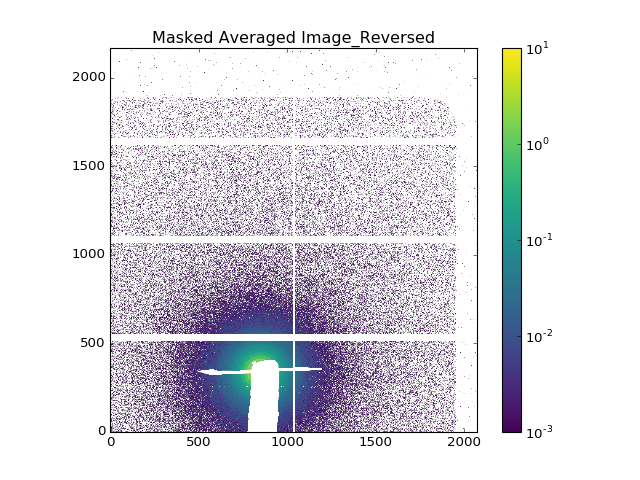

In [60]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgmr, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image_Reversed")
fig.colorbar(im)
plt.show()

## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


## Get the approximate center and see the statistic to make sure 

In [28]:
imgs.md['beam_center_x'], imgs.md['beam_center_y']

(852.0, 1830.0)

In [29]:
#center = (imgs.md['beam_center_x'], imgs.md['beam_center_y'])
center = [ 2167 - 336, 849]  #for not reversed
center = [ 336, 849]  #for reversed
center = [ 2167- 1830, 846]
 
center

[337, 846]

# check the center with a ring
###to be done-->> a better beam center finding algorithm

<IPython.core.display.Javascript object>


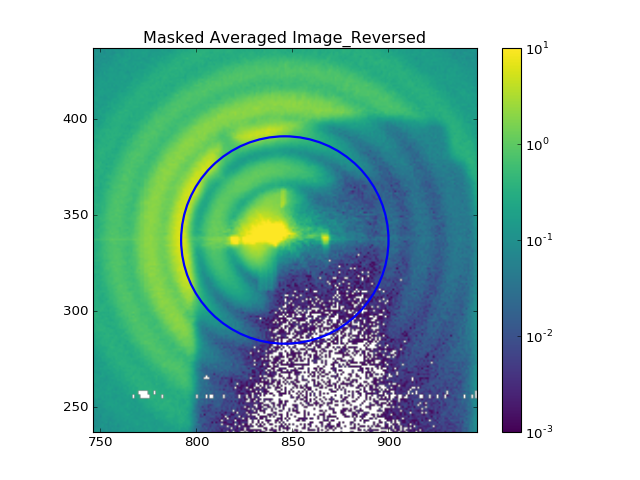

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/patches.py:107: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


In [61]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgr, cmap='viridis',origin='lower', norm= LogNorm(vmin=0.001, vmax=1e1))

radius = 54
circle=plt.Circle( [center[1], center[0]], radius, color='b', alpha=1.0, lw=2, edgecolor='r',fill=False)
plt.gcf().gca().add_artist(circle)


ax.set_title("Masked Averaged Image_Reversed")
fig.colorbar(im)


rwidth = 100 
x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
ax.set_xlim( [x1,x2])
ax.set_ylim( [y1,y2])

plt.show()

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [31]:
bin_centers, ring_averages= circular_average(avg_imgr,  center, pixel_size=(dpix, dpix), mask= maskr)

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

<IPython.core.display.Javascript object>


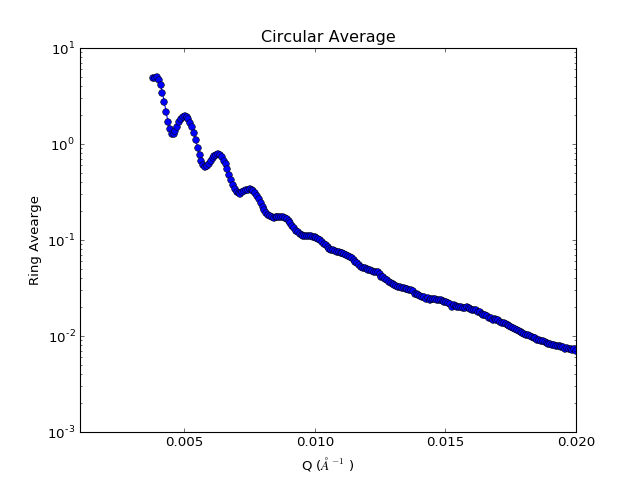

In [62]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title('Circular Average')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Q ('r'$\AA^{-1}$ )')
axes.set_xlim(0.001, 0.02)
axes.set_ylim(0.001, 10.0)
plt.show()

<IPython.core.display.Javascript object>


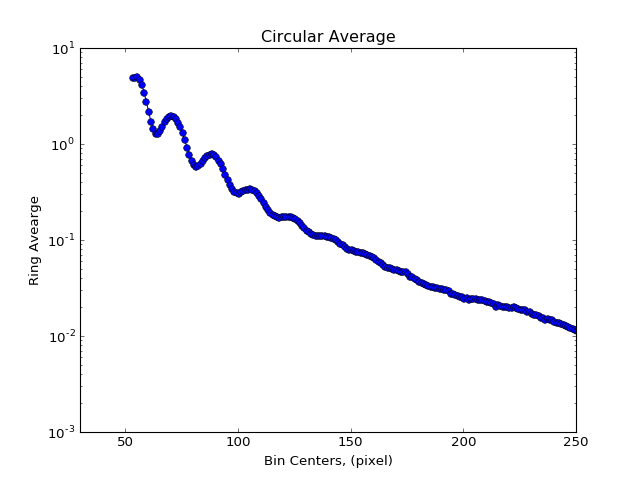

In [63]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(bin_centers/dpix, ring_averages, '-o')
axes.set_title('Circular Average')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers, (pixel)')
axes.set_xlim(30,  250)
axes.set_ylim(0.001, 10.0)
plt.show()

## Create label array (Q rings)

In [34]:
inner_radius = 58 # radius of the first ring
width = 2       # width of each ring
spacing =  (166 - 58)/9 - 2    # spacing between rings
num_rings = 6   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[  58.,   60.],
       [  70.,   72.],
       [  82.,   84.],
       [  94.,   96.],
       [ 106.,  108.],
       [ 118.,  120.]])

In [35]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_center = np.average(q_ring_val, axis=1)
q_ring_center

array([ 0.00419415,  0.0050472 ,  0.00590025,  0.00675329,  0.00760634,
        0.00845939])

In [36]:
rings = roi.rings(edges, center, avg_imgmr.shape)

ring_mask = rings*maskr

## Extract the labeled array

In [37]:
ring_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
qind, pixelist = roi.extract_label_indices(   ring_mask  )
noqs = len( np.unique(qind) )
nopr = np.bincount(qind, minlength=(noqs+1))[1:]  

In [39]:
qind

array([6, 6, 6, ..., 6, 6, 6])

In [40]:
nopr

array([ 128,  312,  459,  583,  848, 1068])

## Number of pixels in each q ring

# check center

<IPython.core.display.Javascript object>


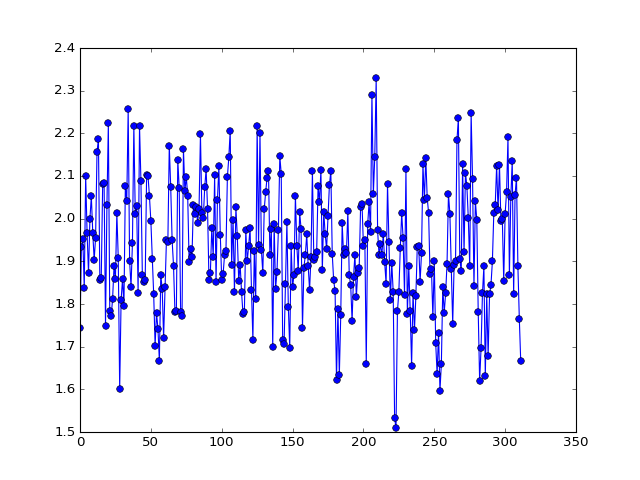

In [64]:
pixel = roi.roi_pixel_values(avg_imgmr, ring_mask, [2] )
fig,ax=plt.subplots()
ax.plot( pixel[0][0] ,'bo', ls='-' )


<IPython.core.display.Javascript object>


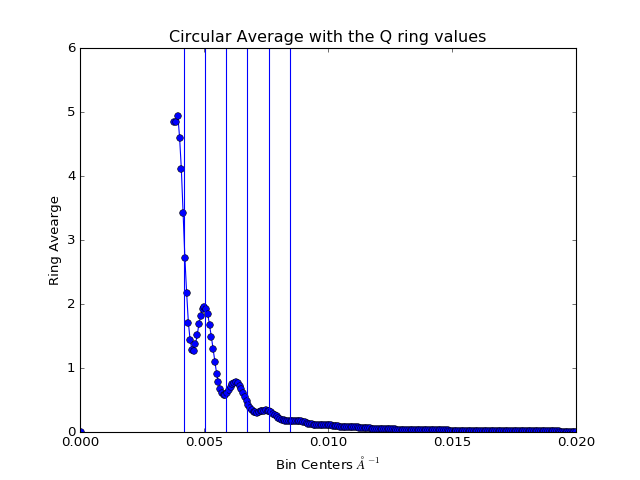

In [65]:
fig, axes = plt.subplots( figsize=(8, 6))
#axes.semilogy(q_val, ring_averages, '-o')
axes.plot(q_val, ring_averages, '-o')
axes.set_title('Circular Average with the Q ring values')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers 'r'$\AA^{-1}$')
axes.set_xlim(0.00, 0.02)
axes.set_ylim(0, 6)
for i in range(num_rings):
    axes.axvline(q_ring_center[i])
plt.show()

In [43]:
#plt.close('all')

<IPython.core.display.Javascript object>


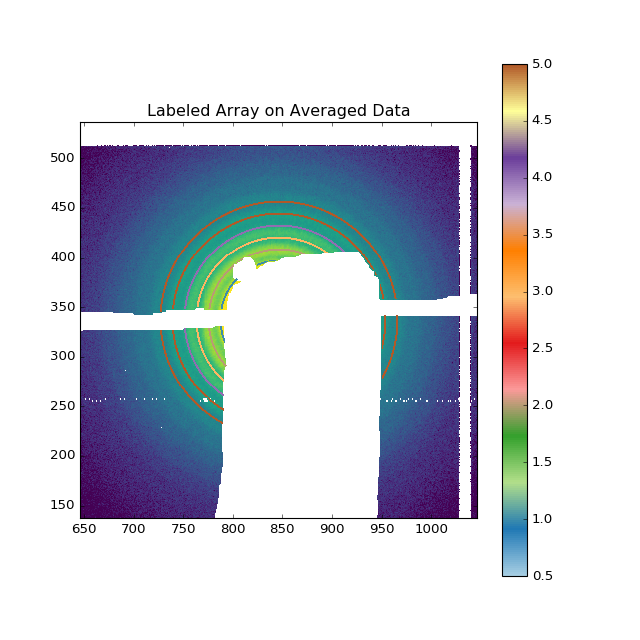

In [67]:

# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array on Averaged Data")
im,im_label = show_label_array_on_image(axes, avg_imgmr, ring_mask, imshow_cmap='viridis',
                        cmap='Paired',
                         vmin=0.01, vmax=5,  origin="lower")
#rwidth = 200 
#x1,x2 = [center[1] - rwidth, center[1] + rwidth]
#y1,y2 = [center[0] - rwidth, center[0] + rwidth]
#axes.set_xlim( [x1,x2])
#axes.set_ylim( [y1,y2])

#fig.colorbar(im)
rwidth = 200 

x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
axes.set_xlim( [x1,x2])
axes.set_ylim( [y1,y2])
fig.colorbar(im_label)
plt.show()

##  Kymograph(waterfall plot) of the max-intensity ring

In [45]:
imgs_ =imgs
imgsr = Reverse_Coordinate(imgs_, mask)    

In [46]:
%run two_time.py

### users put the number of ring with max intensity here

In [47]:
max_inten_ring =2

In [48]:
#kymo = roi.kymograph(imgsr, ring_mask, num = max_inten_ring)

In [49]:
t0 = time.time()
data_pixel =   Get_Pixel_Array( imgsr, pixelist).get_data()
run_time(t0)

Total time: 4.03 min


In [50]:
pixelist_qi =  np.where( qind == 2)[0]         
data_pixel_qi = data_pixel[:,pixelist_qi] 

<IPython.core.display.Javascript object>


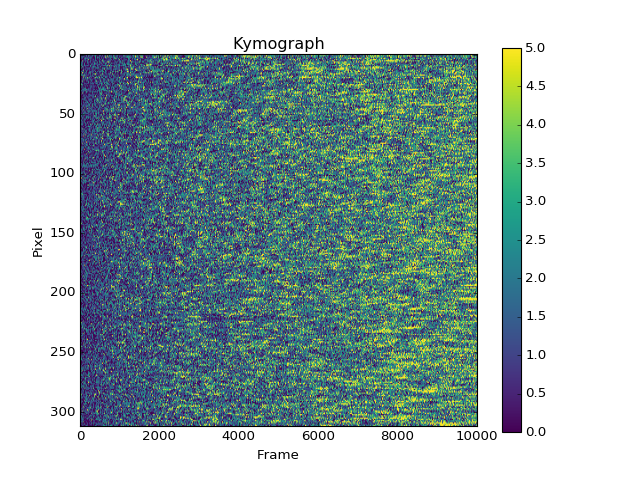

In [68]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph')

im = ax.imshow(data_pixel_qi.T, cmap='viridis', vmax=5.0)
fig.colorbar( im   )
ax.set_aspect(30.)
plt.show()

##  Mean intensities for each ring

In [52]:
mean_inten = get_mean_intensity( data_pixel, qind)

<IPython.core.display.Javascript object>


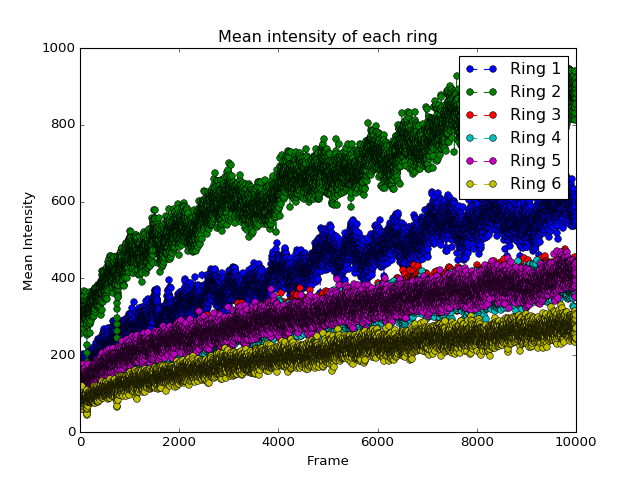

In [69]:
times = np.arange(  mean_inten[1].shape[0]   )  #*timeperframe  # get the time for each frame

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(times, mean_inten[i+1], '--o', label="Ring "+str(i+1))
    ax.set_xlabel("Frame")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py

In [54]:
ring_mask = np.array( ring_mask, dtype=int)

In [70]:
good_start = 0
good_end = 7600
noframes = good_end - good_start
imgs_ =imgs[good_start: good_end-1]
imgsr2 = Reverse_Coordinate(imgs_, mask)    

In [71]:
num_buf = 8
num_lev = int(np.log( noframes/(num_buf-1))/np.log(2) +1) +1
t0 = time.time()
g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf,ring_mask, imgsr2)
lags = lag_steps*timeperframe
run_time(t0)

Total time: 1.63 min


In [72]:
tg2 = np.hstack( [ lags.reshape( len(lags),1), g2] )
#np.save( path + 'g2_%s-%s--%s'%(uid,good_start, good_end), tg2)
np.savetxt( path + 'g2_%s-%s--%s.txt'%(uid,good_start, good_end), tg2)

### Plot the one time correlation functions

<IPython.core.display.Javascript object>


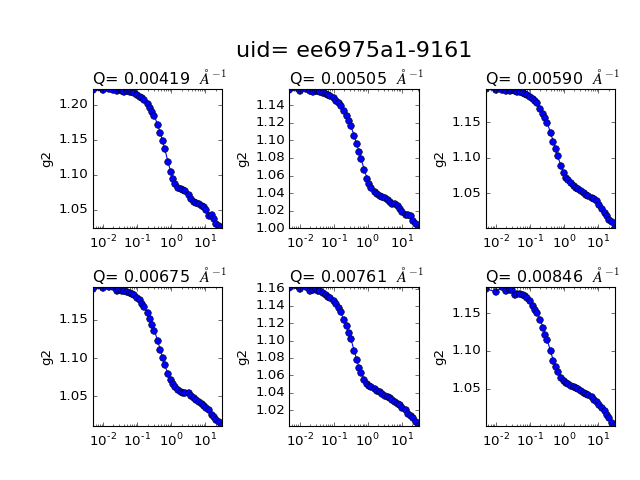

In [91]:


sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid,fontsize=20, y =1.08)  
plt.axis('off')
for sn in range(num_rings):
    ax = fig.add_subplot(sx,sy,sn+1 )
    ax.set_ylabel("g2") 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')
    y=g2[:, sn]
    ax.semilogx(lags, y, '-o', markersize=6) 
    #ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
    ax.set_ylim([    min(y) , max(y[1:]) ])
    ax.set_xlim([   min(lags)+0*1e-6, max(lags)])
plt.show()
fig.tight_layout()  

# Fit g2

In [75]:
from lmfit import  Model
mod = Model(corr.auto_corr_scat_factor)


<IPython.core.display.Javascript object>


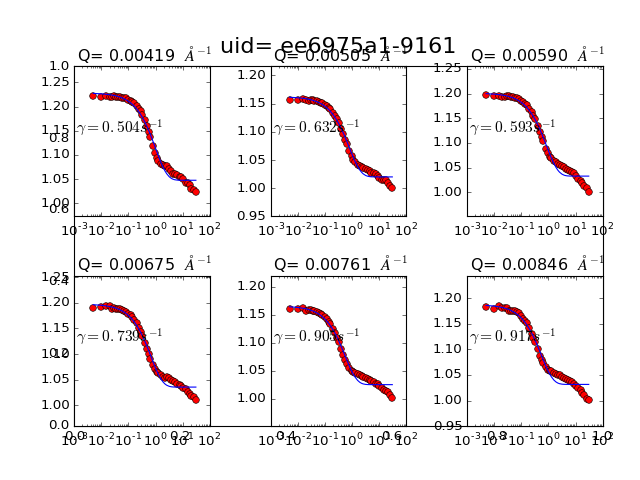

In [92]:
rate = []

sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid, fontsize=20, y =1.02)  
for sn in range(num_rings):
    ax = fig.add_subplot(sx, sy, sn+1 )
    y=g2[1:, sn]
    result1 = mod.fit(y, lags=lags[1:], beta=.1,
                      relaxation_rate =.5, baseline=1.0)
    rate.append(result1.best_values['relaxation_rate'])
    
    ax.semilogx(lags[1:], y, 'ro')
    ax.semilogx(lags[1:], result1.best_fit, '-b')
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
    txts = r'$\gamma$' + r'$ = %.3f$'%(rate[sn]) +  r'$ s^{-1}$'
    ax.text(x =0.015, y=.55, s=txts, fontsize=14, transform=ax.transAxes)              
 
fig.tight_layout()  

## Plot the relaxation rates vs (q_ring_center)**2

<IPython.core.display.Javascript object>


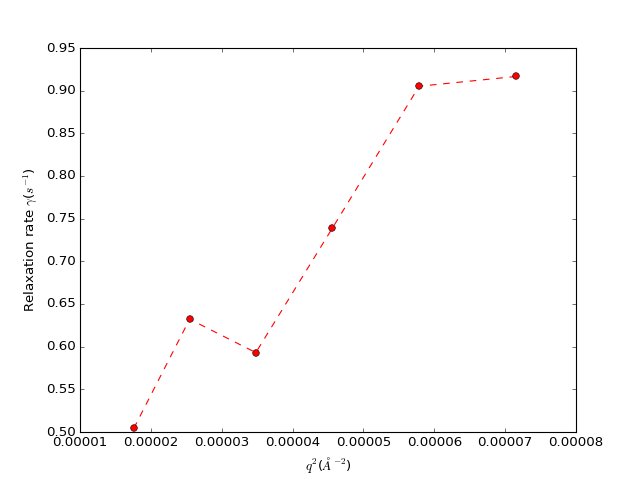

In [93]:
fig, ax=plt.subplots()
ax.plot(q_ring_center**2, rate, 'ro', ls='--')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

# Fitted the Diffusion Coefficinet D0

In [94]:
D0 = np.polyfit(q_ring_center**2, rate, 1)
gmfit = np.poly1d(D0)
print ('The fitted diffusion coefficient D0 is:  %.2E   A^2S-1'%D0[0])

The fitted diffusion coefficient D0 is:  7.99E+03   A^2S-1


<IPython.core.display.Javascript object>


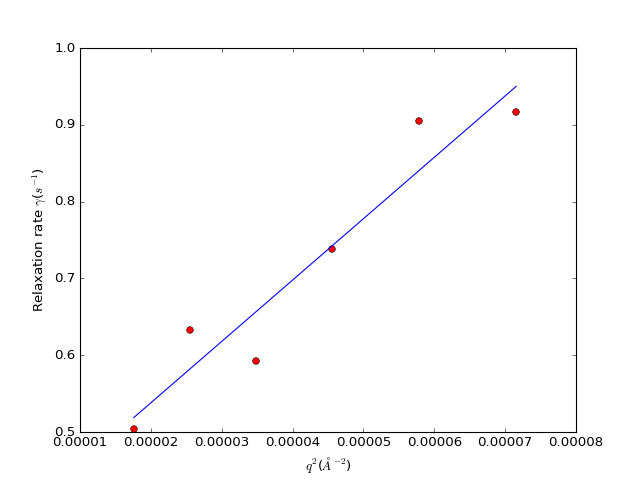

In [95]:
fig,ax = plt.subplots()
ax.plot(q_ring_center**2, rate, 'ro', ls='')
ax.plot(q_ring_center**2,  gmfit(q_ring_center**2),  ls='-')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

# Two_time Correlation

In [81]:
good_start= 0
good_end = 10000
imgs_ =imgs[good_start: good_end]
imgsr = Reverse_Coordinate(imgs_, mask)

In [82]:
#g12b = auto_two_Array( imgsr, ring_mask,  data_pixel = data_pixel ) 
g12b, g12b_not_norm, norms = auto_two_Array_g1_norm( imgsr,
                ring_mask, data_pixel = data_pixel ) 

Total time: 0.47 min


<IPython.core.display.Javascript object>


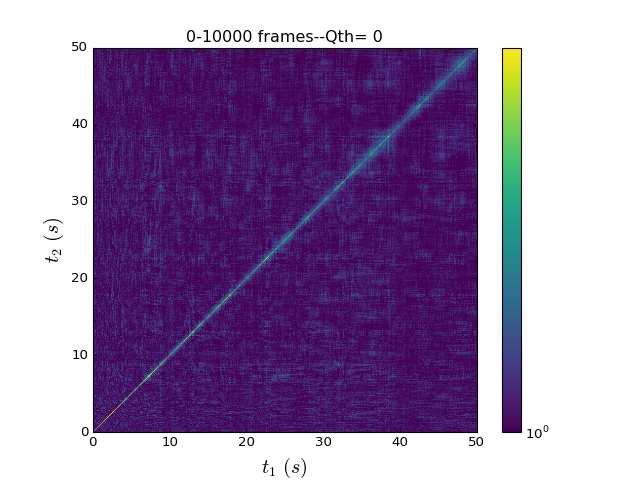

In [96]:
g12_num = 0  #0: the firs ring
data = g12b[:,:,g12_num]
fig, ax = plt.subplots()
im=ax.imshow( data, origin='lower' , cmap='viridis', 
             norm= LogNorm( vmin= 1, vmax= 1.6 ), 
        extent=[0, data.shape[0]*timeperframe, 0, data.shape[0]*timeperframe ] )
ax.set_title('0-%s frames--Qth= %s'%(Nimg,g12_num))
ax.set_xlabel( r'$t_1$ $(s)$', fontsize = 18)
ax.set_ylabel( r'$t_2$ $(s)$', fontsize = 18)
fig.colorbar(im)
plt.show()

## find the bad frames and mask it in two-time correlation

In [84]:
#np.where( g12b[:,:,0] == g12b[:,:,0].min() )

In [85]:
g12b_mask = make_g12_mask(g12b,[7629])
g12bm = masked_g12(g12b,[7629])

### get one time correlation

In [102]:
#g2b = get_one_time_from_two_time(g12bm, timeperframe= timeperframe)
g2b = get_one_time_from_two_time(g12b_not_norm,
                        norms=norms, nopr=nopr, timeperframe= timeperframe)

<IPython.core.display.Javascript object>


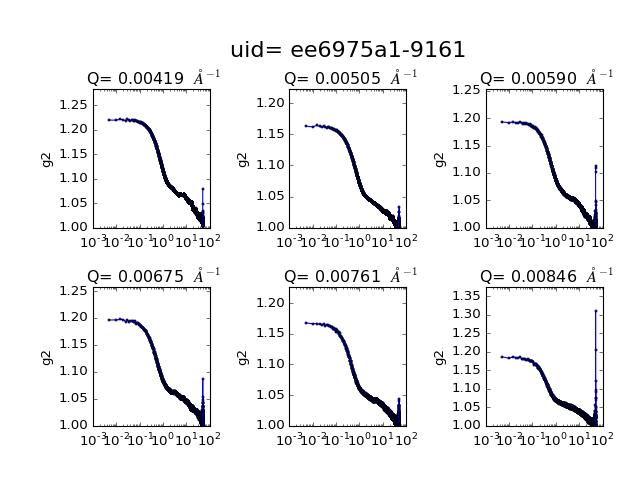

In [104]:
sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid,fontsize=20, y =1.08)  
plt.axis('off')
for sn in range(num_rings):
    ax = fig.add_subplot(sx,sy,sn+1 )
    ax.set_ylabel("g2") 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')     
    y=g2b[:, sn]
    ax.semilogx( np.arange(len(y))*timeperframe, y, '-o', markersize= 2) 
    #ax.semilogx(lags, y, '-o', markersize=6) 
    #ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
    ax.set_ylim( [1.0, max(y[1:])*1.05 ] )
    
plt.show()
fig.tight_layout() 

### plot g2 by multi-tau and g2 from two-time

<IPython.core.display.Javascript object>


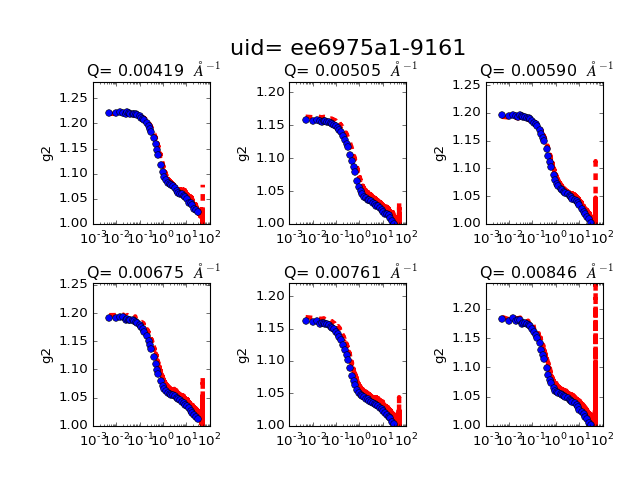

In [107]:
sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid,fontsize=20, y =1.06)  
plt.axis('off')
for sn in range(num_rings):
    ax = fig.add_subplot(sx,sy,sn+1 )
    ax.set_ylabel("g2") 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')     
    y=g2b[:, sn]
    ax.semilogx( np.arange(len(y))*timeperframe, y, '--r', lw =4, markersize=6) 
    
    y2=g2[:, sn]
    ax.semilogx(lags, y2, 'bo', markersize=6) 
    
    #ax.semilogx(lags, y, '-o', markersize=6) 
    #ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
    ax.set_ylim( [1.0, max(y2[1:])*1.05 ] )
plt.show()
fig.tight_layout()     

### get one time correlation @different age

the cut age centers are: [  4000.  10000.  16000.]


<IPython.core.display.Javascript object>


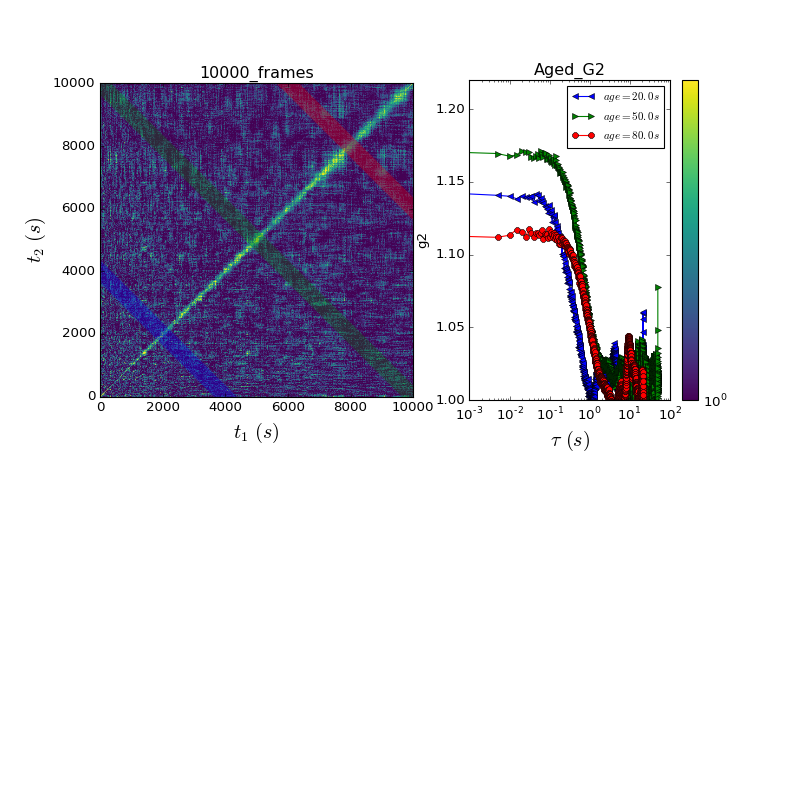

In [108]:
g12_num =0

g2b_age = show_g12_age_cuts( g12bm, g12_num=g12_num, slice_num =3, slice_width= 500, 
                slice_start=4000, slice_end= 20000-4000,
    timeperframe= timeperframe,vmin= 1.0, vmax =  1.22) #vmax=g12b[:,:,g12_num].max() )

# get taus histgram

the cut tau centers are: [  3.00000000e+00   1.25200000e+03   2.50100000e+03   3.75000000e+03
   4.99900000e+03]


<IPython.core.display.Javascript object>


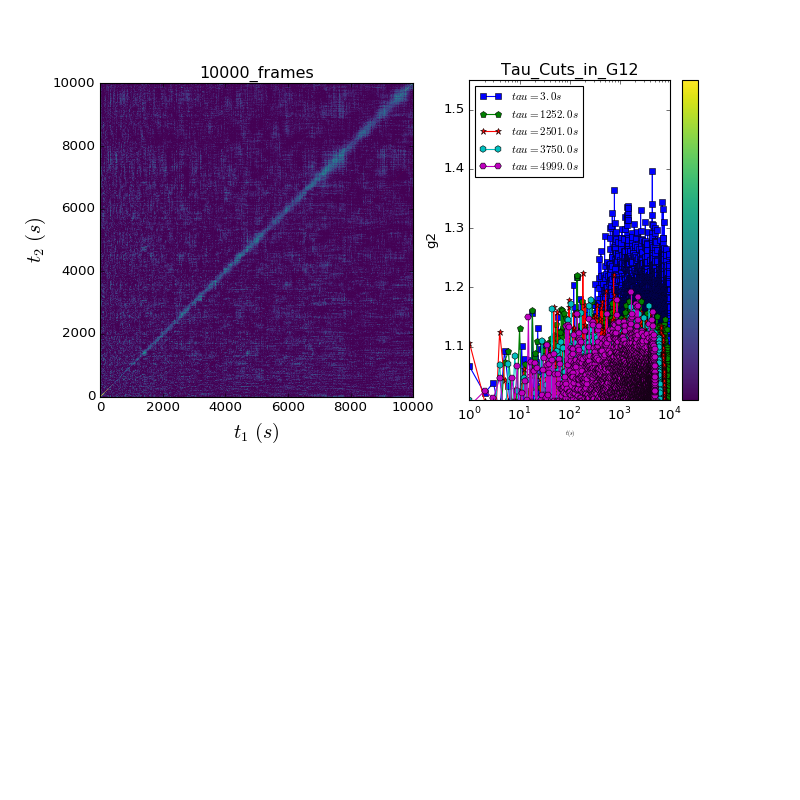

In [109]:
taus = show_g12_tau_cuts(g12bm, g12_num=0,  slice_num = 5, slice_width= 1.0, 
    slice_start=3, slice_end= 5000-1,draw_scale_tau =1.0, vmin=1.01,vmax=1.55 )

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


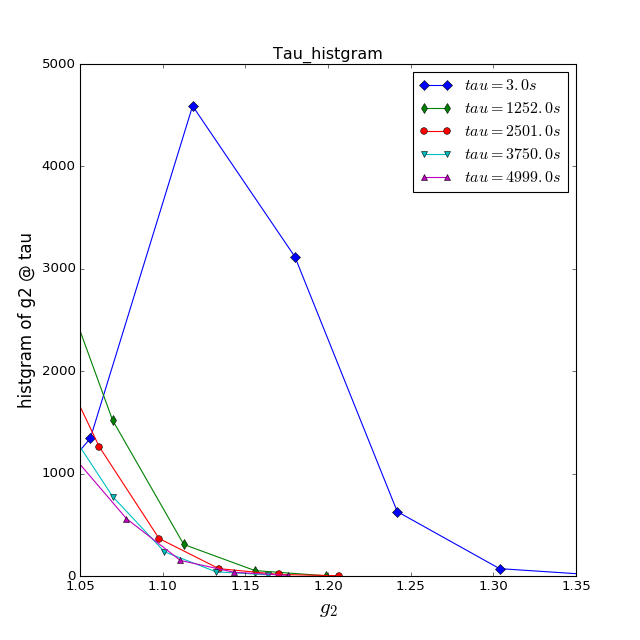

In [110]:
his = his_tau(taus, hisbin = 10, plot=True)